<a href="https://colab.research.google.com/github/ParthBotre/Research2.0/blob/main/notebooks/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!git clone https://github.com/sithu31296/semantic-segmentation
%cd semantic-segmentation
%pip install -e .

fatal: destination path 'semantic-segmentation' already exists and is not an empty directory.
/content/semantic-segmentation
Obtaining file:///content/semantic-segmentation
  Preparing metadata (setup.py) ... done
  Attempting uninstall: semseg
    Found existing installation: semseg 0.4.1
    Uninstalling semseg-0.4.1:
      Successfully uninstalled semseg-0.4.1
  Running setup.py develop for semseg


In [2]:
import torch
from torchvision import io
from torchvision import transforms as T
from PIL import Image

def show_image(image):
    if image.shape[2] != 3: image = image.permute(1, 2, 0)
    image = Image.fromarray(image.numpy())
    return image

## Show Available Pretrained Models

In [3]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  DDRNet
    6  FCHarDNet
    7  BiSeNetv2


## Load a Pretrained Model

Download a pretrained model's weights from the result table (ADE20K, CityScapes, ...) and put it in `checkpoints/pretrained/model_name/`.

In [4]:
%pip install -U gdown

In [5]:
import gdown
from pathlib import Path

ckpt = Path('./checkpoints/pretrained/segformer')
ckpt.mkdir(exist_ok=True, parents=True)

url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT
From (redirected): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT&confirm=t&uuid=79fd76df-47a2-4028-a981-271153546b15
To: /content/semantic-segmentation/checkpoints/pretrained/segformer/segformer.b3.ade.pth
100%|██████████| 190M/190M [00:01<00:00, 120MB/s] 


'./checkpoints/pretrained/segformer/segformer.b3.ade.pth'

In [6]:
from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B3',
    num_classes=150
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map_location='cpu'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()

print('Loaded Model')

Loaded Model


## Simple Image Inference

### Load Image

torch.Size([3, 683, 1024])


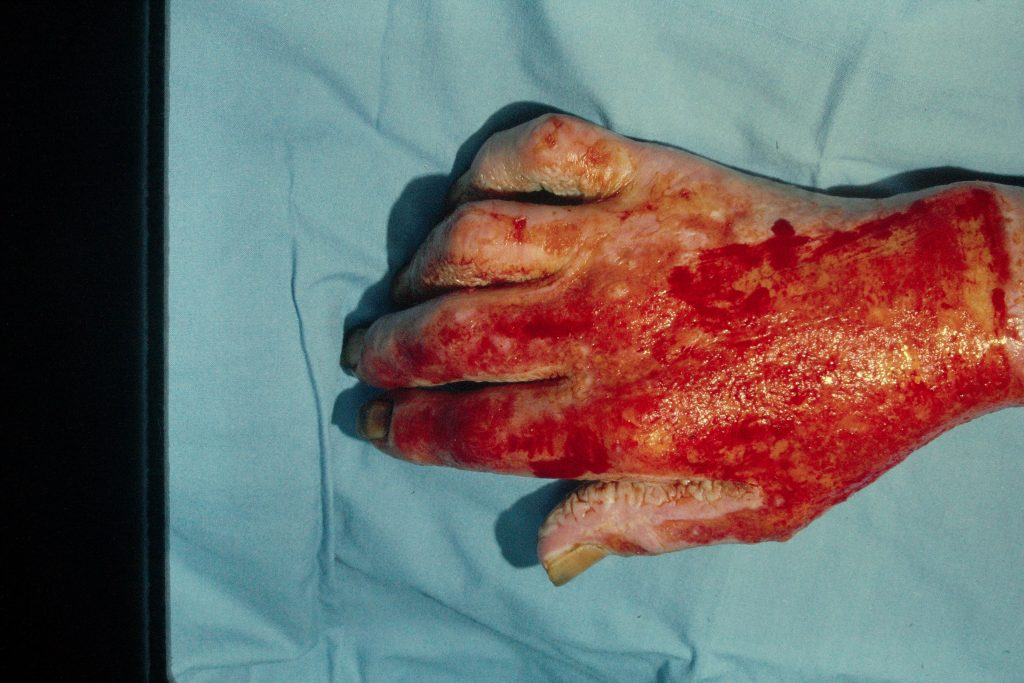

In [22]:
image_path = '/content/semantic-segmentation/assests/ade/test_image.jpg'
image = io.read_image(image_path)
print(image.shape)
show_image(image)

### Preprocess

In [23]:
# resize
image = T.CenterCrop((512, 512))(image)
# scale to [0.0, 1.0]
image = image.float() / 255
# normalize
image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
# add batch size
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 512, 512])

### Model Forward

In [24]:
with torch.inference_mode():
    seg = model(image)
seg.shape

torch.Size([1, 150, 512, 512])

### Postprocess

In [25]:
seg = seg.softmax(1).argmax(1).to(int)
seg.unique()

tensor([  0,  12,  24,  34,  39, 120, 137])

In [26]:
from semseg.datasets import *

palette = eval('ADE20K').PALETTE

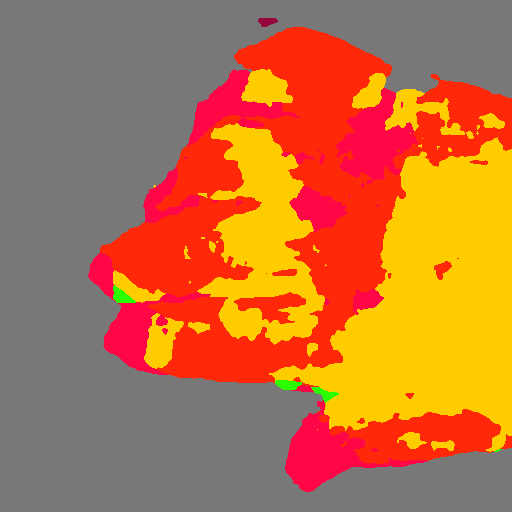

In [27]:
seg_map = palette[seg].squeeze().to(torch.uint8)
show_image(seg_map)

## Show Available Backbones

In [28]:
from semseg import show_backbones

show_backbones()

Backbone Names    Variants
----------------  ------------------------------------
ResNet            ['18', '34', '50', '101', '152']
ResNetD           ['18', '50', '101']
MicroNet          ['M1', 'M2', 'M3']
MobileNetV2       ['1.0']
MobileNetV3       ['S', 'L']
MiT               ['B0', 'B1', 'B2', 'B3', 'B4', 'B5']
PVTv2             ['B1', 'B2', 'B3', 'B4', 'B5']
ResT              ['S', 'B', 'L']
PoolFormer        ['S24', 'S36', 'M36']
ConvNeXt          ['T', 'S', 'B']


## Show Available Heads

In [29]:
from semseg import show_heads

show_heads()

  No.  Heads
-----  -------------
    1  UPerHead
    2  SegFormerHead
    3  SFHead
    4  FPNHead
    5  FaPNHead
    6  FCNHead
    7  CondHead
    8  LawinHead


## Show Available Datasets

In [30]:
from semseg import show_datasets

show_datasets()

  No.  Datasets
-----  ---------------
    1  CamVid
    2  CityScapes
    3  ADE20K
    4  MHPv1
    5  MHPv2
    6  LIP
    7  CIHP
    8  CCIHP
    9  ATR
   10  PASCALContext
   11  COCOStuff
   12  SUIM
   13  SunRGBD
   14  MapillaryVistas
   15  HELEN
   16  LaPa
   17  iBugMask
   18  CelebAMaskHQ
   19  FaceSynthetics


## Construct a Custom Model

### Choose a Backbone

In [31]:
from semseg.models.backbones import ResNet

backbone = ResNet('18')

In [32]:
# init random input batch
x = torch.randn(2, 3, 224, 224)

In [33]:
# get features from the backbone
features = backbone(x)
for out in features:
    print(out.shape)

torch.Size([2, 64, 56, 56])
torch.Size([2, 128, 28, 28])
torch.Size([2, 256, 14, 14])
torch.Size([2, 512, 7, 7])


### Choose a Head

In [34]:
from semseg.models.heads import UPerHead

head = UPerHead(backbone.channels, 128, num_classes=10)

In [35]:
seg = head(features)
seg.shape

torch.Size([2, 10, 56, 56])

In [36]:
from torch.nn import functional as F
# upsample the output
seg = F.interpolate(seg, size=x.shape[-2:], mode='bilinear', align_corners=False)
seg.shape

torch.Size([2, 10, 224, 224])

Check `semseg/models/custom_cnn.py` and `semseg/models/custom_vit.py` for a complete construction for custom model.